In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly import express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go # Plotly graph objects!
import statsmodels.formula.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, KFold, TimeSeriesSplit
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_text

# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

# statsmodels: pretty and good to use, great for interpretable ML
from statsmodels.formula.api import ols, logit
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import Image

# !pip install hide_code
# !jupyter nbextension install --py --user hide_code
# !jupyter nbextension enable --py --user hide_code
# !jupyter serverextension enable --py --user hide_code

In [2]:
import os
os.getcwd()
os.chdir('/Users/az/data_projects/ca_pfl/FMLA')

### Import Datasets and Copy

In [3]:
capfl_o = pd.read_csv('ca_edd_data_05_2024.csv')
capfl = capfl_o.copy(deep=True)

income_o = pd.read_csv('med_house_income_ca_2004_2024.csv')
income = income_o.copy(deep=True)

births_o = pd.read_csv('20241030_number_births.csv')
births_all = births_o.copy(deep = True)

births_new_o = pd.read_csv('CA & County Total Births-Table 1 011425.csv')
births_new = births_new_o.copy(deep = True)

In [4]:
def year_to_month(df, time_index):
    df.set_index('date', inplace = True)
    df = df.resample('M').ffill()
    df = df.reindex(time_index).ffill()
    df = df.reset_index()
    df.rename(columns={'index': 'date'}, inplace = True)
    df.set_index('date', inplace = True)

    return df

### Median Income Data

In [5]:
income.head()

,DATE,MEHOINUSCAA646N
0,2004-01-01,49220
1,2005-01-01,51760
2,2006-01-01,55320
3,2007-01-01,55730
4,2008-01-01,57010


In [6]:
income.tail()

,DATE,MEHOINUSCAA646N
15,2019-01-01,78100
16,2020-01-01,77650
17,2021-01-01,81580
18,2022-01-01,85300
19,2023-01-01,89870


In [7]:
income.rename(columns={
            'MEHOINUSCAA646N': 'median_income',
            'DATE': 'date'}, 
            inplace = True)

income['median_income_logged'] = np.log10(income['median_income'])

income['median_income_weekly'] = income['median_income'] / 52
income['median_55%'] = income['median_income_weekly'] * 0.55

income['median_income_weekly_logged'] = np.log10(income['median_income_weekly'])

income['date'] = pd.to_datetime(income['date'])

income

,date,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged
0,2004-01-01,49220,4.692142,946.538462,520.596154,2.976138
1,2005-01-01,51760,4.713994,995.384615,547.461538,2.997991
2,2006-01-01,55320,4.742882,1063.846154,585.115385,3.026879
3,2007-01-01,55730,4.746089,1071.730769,589.451923,3.030086
4,2008-01-01,57010,4.755951,1096.346154,602.990385,3.039948
5,2009-01-01,56130,4.749195,1079.423077,593.682692,3.033192
6,2010-01-01,54280,4.734640,1043.846154,574.115385,3.018636
7,2011-01-01,53370,4.727297,1026.346154,564.490385,3.011294
8,2012-01-01,57020,4.756027,1096.538462,603.096154,3.040024
9,2013-01-01,60790,4.783832,1169.038462,642.971154,3.067829


In [8]:
t_index = pd.DatetimeIndex(pd.date_range(start='2004-07-01', end='2024-05-31', freq='M'))

income = year_to_month(income, t_index)

In [9]:
income.tail(15)

,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged
date,,,,,
2023-03-31,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-04-30,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-05-31,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-06-30,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-07-31,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-08-31,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-09-30,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-10-31,89870.0,4.953615,1728.269231,950.548077,3.237611
2023-11-30,89870.0,4.953615,1728.269231,950.548077,3.237611


### **Weekly Benefit Maximum Data**

In [10]:
mwba = {
    'Year': [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'max_amt': [603, 728, 840, 882, 917, 959, 987, 987, 1011, 1067, 1075, 1104, 1129, 1173, 1216, 1252, 1300, 1357, 1540, 1620, 1620],
}

mwba = pd.DataFrame(mwba)

mwba['max_amt_change'] = mwba['max_amt'].pct_change() * 100
mwba['date'] = pd.to_datetime(mwba['Year'], format='%Y')

In [11]:
mwba

,Year,max_amt,max_amt_change,date
0,2004,603,NaN,2004-01-01
1,2005,728,20.729685,2005-01-01
2,2006,840,15.384615,2006-01-01
3,2007,882,5.000000,2007-01-01
4,2008,917,3.968254,2008-01-01
5,2009,959,4.580153,2009-01-01
6,2010,987,2.919708,2010-01-01
7,2011,987,0.000000,2011-01-01
8,2012,1011,2.431611,2012-01-01
9,2013,1067,5.539070,2013-01-01


In [12]:
t_index = pd.DatetimeIndex(pd.date_range(start='2004-07-01', end='2024-05-31', freq='M'))

mwba = year_to_month(mwba, t_index)

mwba['Year'] = mwba.index.year
mwba.tail(15)

,Year,max_amt,max_amt_change
date,,,
2023-03-31,2023,1620.0,5.194805
2023-04-30,2023,1620.0,5.194805
2023-05-31,2023,1620.0,5.194805
2023-06-30,2023,1620.0,5.194805
2023-07-31,2023,1620.0,5.194805
2023-08-31,2023,1620.0,5.194805
2023-09-30,2023,1620.0,5.194805
2023-10-31,2023,1620.0,5.194805
2023-11-30,2023,1620.0,5.194805


### **Maximum Number of Weeks for Benefit Data**

Max PFL weeks increased from 6 to 8 weeks on July 1, 2020.

In [13]:
max_weeks = {
    'Year': [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'max_num_weeks': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8],
}

max_weeks = pd.DataFrame(max_weeks)
max_weeks['date'] = pd.to_datetime(max_weeks['Year'], format='%Y')
max_weeks.tail()

,Year,max_num_weeks,date
16,2020,6,2020-01-01
17,2021,8,2021-01-01
18,2022,8,2022-01-01
19,2023,8,2023-01-01
20,2024,8,2024-01-01


In [14]:
t_index = pd.DatetimeIndex(pd.date_range(start='2004-07-01', end='2024-05-31', freq='M'))

In [15]:
max_weeks = year_to_month(max_weeks, t_index)

In [16]:
max_weeks['Year'] = max_weeks.index.year

In [17]:
max_weeks.tail(15)

,Year,max_num_weeks
date,,
2023-03-31,2023,8.0
2023-04-30,2023,8.0
2023-05-31,2023,8.0
2023-06-30,2023,8.0
2023-07-31,2023,8.0
2023-08-31,2023,8.0
2023-09-30,2023,8.0
2023-10-31,2023,8.0
2023-11-30,2023,8.0


In [18]:
max_weeks.index > '2020-06-30'

# Checking how '>' works for dates

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [19]:
max_weeks['max_num_weeks'] = np.where(max_weeks.index > '2020-06-30', '8', '6')

In [20]:
max_weeks['2020-05-31':'2020-08-31']

,Year,max_num_weeks
date,,
2020-05-31,2020,6
2020-06-30,2020,6
2020-07-31,2020,8
2020-08-31,2020,8


### **Number of Births Data - Old**

In [21]:
births_all.head()

,Year,Month,Geography_Type,Strata,Strata_Name,Count,Annotation_Code,Annotation_Desc,Data_Revision_Date
0,1960,1,Occurrence,Total Population,Total Population,28830,NaN,NaN,10/30/2024
1,1960,1,Residence,Total Population,Total Population,28838,NaN,NaN,10/30/2024
2,1960,2,Occurrence,Total Population,Total Population,27873,NaN,NaN,10/30/2024
3,1960,2,Residence,Total Population,Total Population,27913,NaN,NaN,10/30/2024
4,1960,3,Occurrence,Total Population,Total Population,29984,NaN,NaN,10/30/2024


In [22]:
births_all['Date'] = pd.to_datetime(births_all[['Year', 'Month']].assign(Day=1))

In [23]:
births_all.head()

,Year,Month,Geography_Type,Strata,Strata_Name,Count,Annotation_Code,Annotation_Desc,Data_Revision_Date,Date
0,1960,1,Occurrence,Total Population,Total Population,28830,NaN,NaN,10/30/2024,1960-01-01
1,1960,1,Residence,Total Population,Total Population,28838,NaN,NaN,10/30/2024,1960-01-01
2,1960,2,Occurrence,Total Population,Total Population,27873,NaN,NaN,10/30/2024,1960-02-01
3,1960,2,Residence,Total Population,Total Population,27913,NaN,NaN,10/30/2024,1960-02-01
4,1960,3,Occurrence,Total Population,Total Population,29984,NaN,NaN,10/30/2024,1960-03-01


In [24]:
births_all['Date'] = births_all['Date'] + pd.offsets.MonthEnd(0)

In [25]:
births_all.head()

,Year,Month,Geography_Type,Strata,Strata_Name,Count,Annotation_Code,Annotation_Desc,Data_Revision_Date,Date
0,1960,1,Occurrence,Total Population,Total Population,28830,NaN,NaN,10/30/2024,1960-01-31
1,1960,1,Residence,Total Population,Total Population,28838,NaN,NaN,10/30/2024,1960-01-31
2,1960,2,Occurrence,Total Population,Total Population,27873,NaN,NaN,10/30/2024,1960-02-29
3,1960,2,Residence,Total Population,Total Population,27913,NaN,NaN,10/30/2024,1960-02-29
4,1960,3,Occurrence,Total Population,Total Population,29984,NaN,NaN,10/30/2024,1960-03-31


In [26]:
births_all.set_index('Date', inplace=True)

In [27]:
births_all.head()

,Year,Month,Geography_Type,Strata,Strata_Name,Count,Annotation_Code,Annotation_Desc,Data_Revision_Date
Date,,,,,,,,,
1960-01-31,1960,1,Occurrence,Total Population,Total Population,28830,NaN,NaN,10/30/2024
1960-01-31,1960,1,Residence,Total Population,Total Population,28838,NaN,NaN,10/30/2024
1960-02-29,1960,2,Occurrence,Total Population,Total Population,27873,NaN,NaN,10/30/2024
1960-02-29,1960,2,Residence,Total Population,Total Population,27913,NaN,NaN,10/30/2024
1960-03-31,1960,3,Occurrence,Total Population,Total Population,29984,NaN,NaN,10/30/2024


In [28]:
births_sub = births_all['2004-07-31':]

In [29]:
births_sub.head()

,Year,Month,Geography_Type,Strata,Strata_Name,Count,Annotation_Code,Annotation_Desc,Data_Revision_Date
Date,,,,,,,,,
2004-07-31,2004,7,Occurrence,Total Population,Total Population,47322,NaN,NaN,10/30/2024
2004-07-31,2004,7,Residence,Total Population,Total Population,47225,NaN,NaN,10/30/2024
2004-08-31,2004,8,Occurrence,Total Population,Total Population,48035,NaN,NaN,10/30/2024
2004-08-31,2004,8,Residence,Total Population,Total Population,47964,NaN,NaN,10/30/2024
2004-09-30,2004,9,Occurrence,Total Population,Total Population,48570,NaN,NaN,10/30/2024


In [30]:
births_sub.columns

Index(['Year', 'Month', 'Geography_Type', 'Strata', 'Strata_Name', 'Count',
       'Annotation_Code', 'Annotation_Desc', 'Data_Revision_Date'],
      dtype='object')

In [31]:
birth_columns = ['Geography_Type', 'Strata', 'Strata_Name', 'Annotation_Code', 'Annotation_Desc', 'Data_Revision_Date']

births_slim = births_sub.drop(columns = birth_columns)

In [32]:
births_slim.head()

,Year,Month,Count
Date,,,
2004-07-31,2004,7,47322
2004-07-31,2004,7,47225
2004-08-31,2004,8,48035
2004-08-31,2004,8,47964
2004-09-30,2004,9,48570


In [33]:
births_slim.isna().sum()

Year     0
Month    0
Count    0
dtype: int64

In [34]:
births_grouped = births_slim.groupby('Date')['Count'].sum().reset_index()

births_grouped.rename(columns={'Count': 'Total Count of Births'}, inplace=True)

births_grouped.head()


,Date,Total Count of Births
0,2004-07-31,94547
1,2004-08-31,95999
2,2004-09-30,97040
3,2004-10-31,95590
4,2004-11-30,90968


In [35]:
births_grouped.set_index(['Date'], drop = True, inplace = True)

In [36]:
births_grouped.head()

,Total Count of Births
Date,
2004-07-31,94547
2004-08-31,95999
2004-09-30,97040
2004-10-31,95590
2004-11-30,90968


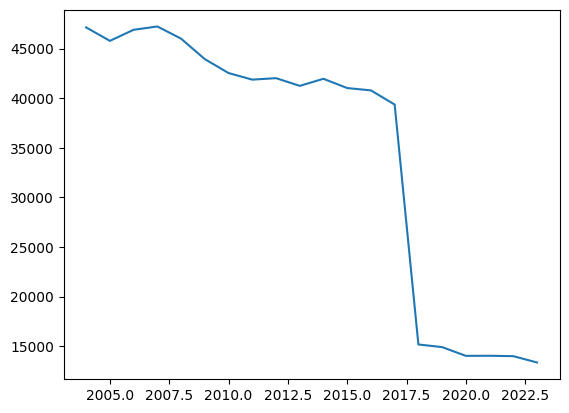

In [37]:
plt.plot(births_slim.groupby('Year')['Count'].mean())

### **Number of Births - New**

In [38]:
births_new.head()

,FIPS,Year,2000,2001,2002,2003,2004,2005,2006,2007,...,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62
0,6000,CALIFORNIA,"531,285","527,371","529,245","540,827","544,685","548,700","562,157","566,089",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
births_new.columns

Index(['FIPS', 'Year', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
       '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033',
       '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042',
       '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050',
       'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59', 'Unnamed: 60',
       'Unnamed: 61', 'Unnamed: 62'],
      dtype='object')

In [40]:
births_new_clean = births_new[['FIPS', 'Year', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024',
       '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033',
       '2034', '2035', '2036', '2037', '2038', '2039', '2040', '2041', '2042',
       '2043', '2044', '2045', '2046', '2047', '2048', '2049', '2050']]

births_new_clean.head()

,FIPS,Year,2000,2001,2002,2003,2004,2005,2006,2007,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,6000,CALIFORNIA,"531,285","527,371","529,245","540,827","544,685","548,700","562,157","566,089",...,"389,318","390,275","390,554","389,336","387,902","385,823","382,729","379,876","375,419","371,521"


In [41]:
births_long = births_new_clean.melt(
    id_vars=["FIPS", "Year"],  # Columns to keep
    var_name="year",          # New column for years
    value_name="births"       # New column for values
)

In [42]:
births_long.head()

,FIPS,Year,year,births
0,6000,CALIFORNIA,2000,"531,285"
1,6000,CALIFORNIA,2001,"527,371"
2,6000,CALIFORNIA,2002,"529,245"
3,6000,CALIFORNIA,2003,"540,827"
4,6000,CALIFORNIA,2004,"544,685"


In [43]:
births_long = births_long.drop(columns = 'Year')

In [44]:
births_long.head()

,FIPS,year,births
0,6000,2000,"531,285"
1,6000,2001,"527,371"
2,6000,2002,"529,245"
3,6000,2003,"540,827"
4,6000,2004,"544,685"


In [45]:
births_long['date'] = pd.to_datetime(births_long['year'], format='%Y')

In [46]:
t_index = pd.DatetimeIndex(pd.date_range(start='2004-07-01', end='2024-05-31', freq='M'))

births = year_to_month(births_long, t_index)

births['Year'] = births.index.year
births.tail(15)

,FIPS,year,births,Year
date,,,,
2023-03-31,6000,2023,"398,783",2023
2023-04-30,6000,2023,"398,783",2023
2023-05-31,6000,2023,"398,783",2023
2023-06-30,6000,2023,"398,783",2023
2023-07-31,6000,2023,"398,783",2023
2023-08-31,6000,2023,"398,783",2023
2023-09-30,6000,2023,"398,783",2023
2023-10-31,6000,2023,"398,783",2023
2023-11-30,6000,2023,"398,783",2023


In [47]:
births.drop(columns = ['FIPS', 'year'], inplace = True)

In [48]:
births.head()

,births,Year
date,,
2004-07-31,"544,685",2004
2004-08-31,"544,685",2004
2004-09-30,"544,685",2004
2004-10-31,"544,685",2004
2004-11-30,"544,685",2004


In [49]:
births['births'] = births['births'].str.replace(",", "")

births['births'] = births['births'].astype('int64')

In [50]:
births.head()

,births,Year
date,,
2004-07-31,544685,2004
2004-08-31,544685,2004
2004-09-30,544685,2004
2004-10-31,544685,2004
2004-11-30,544685,2004


In [51]:
births['births'] = births['births'] / 12

In [52]:
births.head()

,births,Year
date,,
2004-07-31,45390.416667,2004
2004-08-31,45390.416667,2004
2004-09-30,45390.416667,2004
2004-10-31,45390.416667,2004
2004-11-30,45390.416667,2004


In [53]:
births.iloc[[5]] * 12

,births,Year
date,,
2004-12-31,544685.0,24048


### **CA PFL Data**

In [54]:
capfl.head()

,Date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized
0,5/31/2024,May,2024,"25,079","20,449","4,624","22,851","19,561","3,613",934.67,"168,946",7.27,"$157,908,442.00"
1,4/30/2024,April,2024,"26,996","22,913","4,074","24,597","21,653","3,237",927.11,"180,891",7.17,"$167,706,275.00"
2,3/31/2024,March,2024,"24,675","20,433","4,238","23,203","19,834","3,531",924.10,"166,119",7.12,"$153,511,365.00"
3,2/29/2024,February,2024,"26,847","22,735","4,100","24,430","21,488","3,129",931.54,"175,395",7.14,"$163,387,745.00"
4,1/31/2024,January,2024,"30,181","26,107","4,063","27,184","24,256","3,087",930.58,"207,504",7.15,"$193,099,365.00"


In [55]:
for column in capfl.columns:
    if capfl[column].dtype == 'object':
        capfl[column] = capfl[column].str.replace(",", "")
    elif capfl[column].dtype in ['int64', 'float64']: 
        capfl[column] = capfl[column].astype(str).str.replace(",", "").astype(float)

In [56]:
capfl.head()

,Date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized
0,5/31/2024,May,2024.0,25079,20449,4624,22851,19561,3613,934.67,168946,7.27,$157908442.00
1,4/30/2024,April,2024.0,26996,22913,4074,24597,21653,3237,927.11,180891,7.17,$167706275.00
2,3/31/2024,March,2024.0,24675,20433,4238,23203,19834,3531,924.10,166119,7.12,$153511365.00
3,2/29/2024,February,2024.0,26847,22735,4100,24430,21488,3129,931.54,175395,7.14,$163387745.00
4,1/31/2024,January,2024.0,30181,26107,4063,27184,24256,3087,930.58,207504,7.15,$193099365.00


In [57]:
capfl['Date'] = pd.to_datetime(capfl['Date'])
capfl.head()

,Date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized
0,2024-05-31,May,2024.0,25079,20449,4624,22851,19561,3613,934.67,168946,7.27,$157908442.00
1,2024-04-30,April,2024.0,26996,22913,4074,24597,21653,3237,927.11,180891,7.17,$167706275.00
2,2024-03-31,March,2024.0,24675,20433,4238,23203,19834,3531,924.10,166119,7.12,$153511365.00
3,2024-02-29,February,2024.0,26847,22735,4100,24430,21488,3129,931.54,175395,7.14,$163387745.00
4,2024-01-31,January,2024.0,30181,26107,4063,27184,24256,3087,930.58,207504,7.15,$193099365.00


In [58]:
capfl.dtypes

Date                                        datetime64[ns]
Month                                               object
Year                                               float64
Total PFL First Claims Filed                        object
Bonding Claims Filed                                object
Care Claims Filed                                   object
Total PFL First Claims Paid                         object
Bonding Claims Paid                                 object
Care Claims Paid                                    object
PFL Average Weekly Benefit Amount (AWBA)           float64
Weeks Compensated                                   object
Average Duration                                   float64
Total Benefits Authorized                           object
dtype: object

In [59]:
new_dtypes_int = {}
int_dtypes = ["Total PFL First Claims Filed", "Bonding Claims Filed", "Care Claims Filed", "Total PFL First Claims Paid", "Bonding Claims Paid","Care Claims Paid", "Weeks Compensated", "Weeks Compensated"]

for item in int_dtypes:
    new_dtypes_int.update({item: "int64"}) 

capfl = capfl.astype(new_dtypes_int)
# capfl.dtypes

In [60]:
capfl['Total Benefits Authorized'] = capfl['Total Benefits Authorized'].str.replace("$","").astype('float64')

In [61]:
new_dtypes_obj = {}

for column in capfl.columns:    
    if capfl[column].dtype == 'object':
        new_dtypes_obj.update({column: "category"}) 

capfl = capfl.astype(new_dtypes_obj)
capfl.dtypes

Date                                        datetime64[ns]
Month                                             category
Year                                               float64
Total PFL First Claims Filed                         int64
Bonding Claims Filed                                 int64
Care Claims Filed                                    int64
Total PFL First Claims Paid                          int64
Bonding Claims Paid                                  int64
Care Claims Paid                                     int64
PFL Average Weekly Benefit Amount (AWBA)           float64
Weeks Compensated                                    int64
Average Duration                                   float64
Total Benefits Authorized                          float64
dtype: object

In [62]:
capfl['Month'] = capfl.Month.cat.reorder_categories(
    new_categories = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                     'October', 'November', 'December'],
    ordered = True)

In [63]:
capfl.columns

Index(['Date', 'Month', 'Year', 'Total PFL First Claims Filed',
       'Bonding Claims Filed', 'Care Claims Filed',
       'Total PFL First Claims Paid', 'Bonding Claims Paid',
       'Care Claims Paid', 'PFL Average Weekly Benefit Amount (AWBA)',
       'Weeks Compensated', 'Average Duration', 'Total Benefits Authorized'],
      dtype='object')

In [64]:
capfl.head()

,Date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized
0,2024-05-31,May,2024.0,25079,20449,4624,22851,19561,3613,934.67,168946,7.27,157908442.0
1,2024-04-30,April,2024.0,26996,22913,4074,24597,21653,3237,927.11,180891,7.17,167706275.0
2,2024-03-31,March,2024.0,24675,20433,4238,23203,19834,3531,924.10,166119,7.12,153511365.0
3,2024-02-29,February,2024.0,26847,22735,4100,24430,21488,3129,931.54,175395,7.14,163387745.0
4,2024-01-31,January,2024.0,30181,26107,4063,27184,24256,3087,930.58,207504,7.15,193099365.0


In [65]:
# Logging variables
capfl['Total Benefits Authorized Logged'] = np.log10(capfl['Total Benefits Authorized'])

In [66]:
# # 2004 and 2024 removed from CA PFL dataset (not enough data for 2004 or 2024)
# capfl_sub = capfl[~capfl['Year'].isin([2004, 2024])].copy()

In [67]:
# Checking for NAs
capfl.isna().sum()

Date                                         0
Month                                        0
Year                                         0
Total PFL First Claims Filed                 0
Bonding Claims Filed                         0
Care Claims Filed                            0
Total PFL First Claims Paid                  0
Bonding Claims Paid                          0
Care Claims Paid                             0
PFL Average Weekly Benefit Amount (AWBA)     0
Weeks Compensated                            0
Average Duration                            11
Total Benefits Authorized                    0
Total Benefits Authorized Logged             0
dtype: int64

In [68]:
capfl[capfl['Average Duration'].isna()]

,Date,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged
228,2005-05-31,May,2005.0,12007,10531,1476,11545,10193,1352,421.92,62298,NaN,26284761.0,7.419704
229,2005-04-30,April,2005.0,15534,13444,2088,14361,12758,1603,413.11,70288,NaN,29036867.0,7.462950
230,2005-03-31,March,2005.0,11421,9868,1553,10888,9549,1339,410.89,61203,NaN,25147702.0,7.400498
231,2005-02-28,February,2005.0,10052,8868,1184,9730,8707,1023,408.93,57004,NaN,23310658.0,7.367555
232,2005-01-31,January,2005.0,13029,11754,1275,12719,11473,1246,401.12,66725,NaN,26764715.0,7.427563
233,2004-12-31,December,2004.0,13259,11492,1767,12812,11508,1535,404.84,69565,NaN,28162525.0,7.449672
234,2004-11-30,November,2004.0,11571,10037,1534,10922,9722,1265,406.70,61517,NaN,25019053.0,7.398271
235,2004-10-31,October,2004.0,12890,11126,1764,11581,10157,1489,406.39,60366,NaN,24531891.0,7.389731
236,2004-09-30,September,2004.0,12555,10904,1651,11898,10506,1405,409.56,60322,NaN,24705246.0,7.392789
237,2004-08-31,August,2004.0,18885,16503,2382,16214,14771,1443,408.27,78326,NaN,31978400.0,7.504857


In [69]:
# Interpolating missing data for average duration
capfl['Average Duration'] = capfl['Average Duration'].interpolate(method = 'linear')

In [70]:
# Checking that interpolation worked
capfl.isna().sum()

Date                                        0
Month                                       0
Year                                        0
Total PFL First Claims Filed                0
Bonding Claims Filed                        0
Care Claims Filed                           0
Total PFL First Claims Paid                 0
Bonding Claims Paid                         0
Care Claims Paid                            0
PFL Average Weekly Benefit Amount (AWBA)    0
Weeks Compensated                           0
Average Duration                            0
Total Benefits Authorized                   0
Total Benefits Authorized Logged            0
dtype: int64

In [71]:
capfl.set_index(['Date'], drop = True, inplace = True)

In [72]:
capfl = capfl.sort_values('Date')

In [73]:
capfl.head()

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged
Date,,,,,,,,,,,,,
2004-07-31,July,2004.0,5296,2916,2380,3621,2763,858,388.95,13102,5.23,5095960.0,6.707226
2004-08-31,August,2004.0,18885,16503,2382,16214,14771,1443,408.27,78326,5.23,31978400.0,7.504857
2004-09-30,September,2004.0,12555,10904,1651,11898,10506,1405,409.56,60322,5.23,24705246.0,7.392789
2004-10-31,October,2004.0,12890,11126,1764,11581,10157,1489,406.39,60366,5.23,24531891.0,7.389731
2004-11-30,November,2004.0,11571,10037,1534,10922,9722,1265,406.70,61517,5.23,25019053.0,7.398271


In [74]:
capfl.tail()

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged
Date,,,,,,,,,,,,,
2024-01-31,January,2024.0,30181,26107,4063,27184,24256,3087,930.58,207504,7.15,193099365.0,8.285781
2024-02-29,February,2024.0,26847,22735,4100,24430,21488,3129,931.54,175395,7.14,163387745.0,8.213219
2024-03-31,March,2024.0,24675,20433,4238,23203,19834,3531,924.10,166119,7.12,153511365.0,8.186141
2024-04-30,April,2024.0,26996,22913,4074,24597,21653,3237,927.11,180891,7.17,167706275.0,8.224549
2024-05-31,May,2024.0,25079,20449,4624,22851,19561,3613,934.67,168946,7.27,157908442.0,8.198405


In [75]:
capfl['Year'] = capfl.index.year

In [76]:
capfl.head()

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged
Date,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,5.23,5095960.0,6.707226
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,5.23,31978400.0,7.504857
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,5.23,24705246.0,7.392789
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,5.23,24531891.0,7.389731
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,5.23,25019053.0,7.398271


In [77]:
monthly_counts = capfl['Year'].resample('M').count()
monthly_counts.index = monthly_counts.index.to_period('M').to_timestamp()

In [78]:
monthly_counts.isna().value_counts()

Year
False    239
Name: count, dtype: int64

# Merging Datasets

In [79]:
capfl_merged = pd.merge(capfl, income, 'outer', left_index=True, right_index=True)

In [80]:
capfl_merged.head()

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,Average Duration,Total Benefits Authorized,Total Benefits Authorized Logged,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged
Date,,,,,,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,5.23,5095960.0,6.707226,49220.0,4.692142,946.538462,520.596154,2.976138
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,5.23,31978400.0,7.504857,49220.0,4.692142,946.538462,520.596154,2.976138
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,5.23,24705246.0,7.392789,49220.0,4.692142,946.538462,520.596154,2.976138
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,5.23,24531891.0,7.389731,49220.0,4.692142,946.538462,520.596154,2.976138
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,5.23,25019053.0,7.398271,49220.0,4.692142,946.538462,520.596154,2.976138


In [81]:
capfl_merged = pd.merge(capfl_merged, mwba, 'outer', left_index=True, right_index=True)

In [82]:
capfl_merged.head(20)

,Month,Year_x,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,Total Benefits Authorized,Total Benefits Authorized Logged,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,Year_y,max_amt,max_amt_change
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,...,5095960.0,6.707226,49220.0,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,...,31978400.0,7.504857,49220.0,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,...,24705246.0,7.392789,49220.0,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,...,24531891.0,7.389731,49220.0,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,...,25019053.0,7.398271,49220.0,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN
2004-12-31,December,2004,13259,11492,1767,12812,11508,1535,404.84,69565,...,28162525.0,7.449672,49220.0,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN
2005-01-31,January,2005,13029,11754,1275,12719,11473,1246,401.12,66725,...,26764715.0,7.427563,51760.0,4.713994,995.384615,547.461538,2.997991,2005,728.0,20.729685
2005-02-28,February,2005,10052,8868,1184,9730,8707,1023,408.93,57004,...,23310658.0,7.367555,51760.0,4.713994,995.384615,547.461538,2.997991,2005,728.0,20.729685
2005-03-31,March,2005,11421,9868,1553,10888,9549,1339,410.89,61203,...,25147702.0,7.400498,51760.0,4.713994,995.384615,547.461538,2.997991,2005,728.0,20.729685


In [83]:
capfl_merged = pd.merge(capfl_merged, max_weeks, 'outer', left_index=True, right_index=True)

In [84]:
capfl_merged.tail()

,Month,Year_x,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,Year_y,max_amt,max_amt_change,Year,max_num_weeks
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-31,January,2024,30181,26107,4063,27184,24256,3087,930.58,207504,...,89870.0,4.953615,1728.269231,950.548077,3.237611,2024,1620.0,0.0,2024,8
2024-02-29,February,2024,26847,22735,4100,24430,21488,3129,931.54,175395,...,89870.0,4.953615,1728.269231,950.548077,3.237611,2024,1620.0,0.0,2024,8
2024-03-31,March,2024,24675,20433,4238,23203,19834,3531,924.10,166119,...,89870.0,4.953615,1728.269231,950.548077,3.237611,2024,1620.0,0.0,2024,8
2024-04-30,April,2024,26996,22913,4074,24597,21653,3237,927.11,180891,...,89870.0,4.953615,1728.269231,950.548077,3.237611,2024,1620.0,0.0,2024,8
2024-05-31,May,2024,25079,20449,4624,22851,19561,3613,934.67,168946,...,89870.0,4.953615,1728.269231,950.548077,3.237611,2024,1620.0,0.0,2024,8


In [85]:
births.drop(columns = ['Year'], inplace = True)

In [86]:
capfl_merged = pd.merge(capfl_merged, births, 'outer', left_index=True, right_index=True)

In [87]:
capfl_merged.head()

,Month,Year_x,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,Year_y,max_amt,max_amt_change,Year,max_num_weeks,births
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,...,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN,2004,6,45390.416667
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,...,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN,2004,6,45390.416667
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,...,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN,2004,6,45390.416667
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,...,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN,2004,6,45390.416667
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,...,4.692142,946.538462,520.596154,2.976138,2004,603.0,NaN,2004,6,45390.416667


In [88]:
capfl_merged.columns

Index(['Month', 'Year_x', 'Total PFL First Claims Filed',
       'Bonding Claims Filed', 'Care Claims Filed',
       'Total PFL First Claims Paid', 'Bonding Claims Paid',
       'Care Claims Paid', 'PFL Average Weekly Benefit Amount (AWBA)',
       'Weeks Compensated', 'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'Year_y', 'max_amt', 'max_amt_change',
       'Year', 'max_num_weeks', 'births'],
      dtype='object')

In [89]:
capfl_merged = capfl_merged.drop(columns=['Year_y'])

In [90]:
capfl_merged.columns

Index(['Month', 'Year_x', 'Total PFL First Claims Filed',
       'Bonding Claims Filed', 'Care Claims Filed',
       'Total PFL First Claims Paid', 'Bonding Claims Paid',
       'Care Claims Paid', 'PFL Average Weekly Benefit Amount (AWBA)',
       'Weeks Compensated', 'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change', 'Year',
       'max_num_weeks', 'births'],
      dtype='object')

In [91]:
capfl_merged.head()

,Month,Year_x,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,max_amt,max_amt_change,Year,max_num_weeks,births
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,2004,6,45390.416667
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,2004,6,45390.416667
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,2004,6,45390.416667
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,2004,6,45390.416667
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,2004,6,45390.416667


In [92]:
capfl_merged = capfl_merged.drop(columns=['Year'])

In [93]:
capfl_merged.columns

Index(['Month', 'Year_x', 'Total PFL First Claims Filed',
       'Bonding Claims Filed', 'Care Claims Filed',
       'Total PFL First Claims Paid', 'Bonding Claims Paid',
       'Care Claims Paid', 'PFL Average Weekly Benefit Amount (AWBA)',
       'Weeks Compensated', 'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change',
       'max_num_weeks', 'births'],
      dtype='object')

In [94]:
capfl_merged.rename(columns={
            'Year_x': 'Year'}, 
            inplace = True)

In [95]:
capfl_merged.columns

Index(['Month', 'Year', 'Total PFL First Claims Filed', 'Bonding Claims Filed',
       'Care Claims Filed', 'Total PFL First Claims Paid',
       'Bonding Claims Paid', 'Care Claims Paid',
       'PFL Average Weekly Benefit Amount (AWBA)', 'Weeks Compensated',
       'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change',
       'max_num_weeks', 'births'],
      dtype='object')

In [96]:
capfl_merged['2023-01-01':'2024-01-01']

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,Total Benefits Authorized Logged,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,max_amt,max_amt_change,max_num_weeks,births
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-31,January,2023,29129,25548,3573,25269,22872,2394,874.21,183853,...,8.206090,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-02-28,February,2023,24575,21338,3231,22054,19695,2352,876.74,161924,...,8.152180,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-03-31,March,2023,27649,22147,5493,24176,20207,3967,884.07,178750,...,8.198730,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-04-30,April,2023,27513,23597,3908,24691,21602,3086,892.74,166444,...,8.171994,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-05-31,May,2023,35872,29482,6377,31401,27091,4304,903.60,202785,...,8.263011,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-06-30,June,2023,25095,20356,4728,24547,20339,4204,905.52,174872,...,8.199616,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-07-31,July,2023,28143,24700,3428,24949,21995,2963,909.39,176254,...,8.204890,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-08-31,August,2023,30123,24549,5566,27657,23421,4232,924.50,187923,...,8.239889,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667
2023-09-30,September,2023,22908,19104,3794,22628,19126,3499,921.52,165971,...,8.184537,89870.0,4.953615,1728.269231,950.548077,3.237611,1620.0,5.194805,8,33231.916667


In [97]:
capfl_merged['Year']

Date
2004-07-31    2004
2004-08-31    2004
2004-09-30    2004
2004-10-31    2004
2004-11-30    2004
              ... 
2024-01-31    2024
2024-02-29    2024
2024-03-31    2024
2024-04-30    2024
2024-05-31    2024
Name: Year, Length: 239, dtype: int32

In [98]:
pd.to_datetime(capfl_merged['Year']).dt.strftime('%Y')

Date
2004-07-31    1970
2004-08-31    1970
2004-09-30    1970
2004-10-31    1970
2004-11-30    1970
              ... 
2024-01-31    1970
2024-02-29    1970
2024-03-31    1970
2024-04-30    1970
2024-05-31    1970
Name: Year, Length: 239, dtype: object

In [99]:
months_first_half = ['January', 'February', 'March', 'April', 'May', 'June']
months_second_half = ['July', 'August', 'September', 'October', 'November', 'December']

In [100]:
capfl_merged['Month'].isna()

Date
2004-07-31    False
2004-08-31    False
2004-09-30    False
2004-10-31    False
2004-11-30    False
              ...  
2024-01-31    False
2024-02-29    False
2024-03-31    False
2024-04-30    False
2024-05-31    False
Name: Month, Length: 239, dtype: bool

In [101]:
capfl_merged['Month'][0] == months_second_half[0]

/var/folders/l7/dn0hll995195kvrl49_9xmp40000gn/T/ipykernel_73602/1281638032.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capfl_merged['Month'][0] == months_second_half[0]


True

In [102]:
capfl_merged['Month'] = capfl_merged['Month'].str.strip().str.capitalize()

In [103]:
capfl_merged.index = pd.to_datetime(capfl_merged.index)

In [104]:
print(capfl_merged['Month'].isin(months_second_half))


Date
2004-07-31     True
2004-08-31     True
2004-09-30     True
2004-10-31     True
2004-11-30     True
              ...  
2024-01-31    False
2024-02-29    False
2024-03-31    False
2024-04-30    False
2024-05-31    False
Name: Month, Length: 239, dtype: bool


In [105]:
conditions = [
    ((capfl_merged['Year'] == '2004') & (capfl_merged['Month'].isin(months_second_half)))
]

values = ['04_05']
capfl_merged['Fiscal Year'] = np.select(conditions, values, default=np.nan)


In [106]:
# conditions = [
#     (capfl_merged['Month'].isin(months_second_half)) & (capfl_merged.index.year == 2004), # July - Dec 2004
#     (capfl_merged['Month'].isin(months_first_half)) & (capfl_merged.index.year == 2005), # Dec - June 2005
#     (capfl_merged['Month'].isin(months_second_half)) & (capfl_merged.index.year == 2005), # July - Dec 2005
#     (capfl_merged['Month'].isin(months_first_half)) & (capfl_merged.index.year == 2005), # Jan - June 2005
# ]

# # create a list of the values we want to assign for each condition
# values = ['04_05', '04_05', '05_06', '05_06']

# # create a new column and use np.select to assign values to it using our lists as arguments
# capfl_merged['Fiscal Year'] = np.select(conditions, values, default = np.nan)

In [107]:
capfl_merged.head()

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,max_amt,max_amt_change,max_num_weeks,births,Fiscal Year
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,nan
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,nan
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,nan
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,nan
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,...,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,nan


In [108]:
capfl_merged.index = pd.to_datetime(capfl_merged.index)   

In [109]:
capfl_merged['Month_Num'] = capfl_merged.index.month
capfl_merged['Year'] = capfl_merged.index.year

In [110]:
capfl_merged['Fiscal Year'] = (
    (capfl_merged['Year'] - (capfl_merged['Month_Num'] <= 6)).astype(str).str[-2:] + '_' +
    (capfl_merged['Year'] + (capfl_merged['Month_Num'] >= 7)).astype(str).str[-2:]
) 

In [111]:
capfl_merged.head()

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,max_amt,max_amt_change,max_num_weeks,births,Fiscal Year,Month_Num
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,7
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,8
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,9
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,10
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,11


In [112]:
# Check results
print(capfl_merged[['Month', 'Month_Num', 'Year', 'Fiscal Year']].values)

[['July' 7 2004 '04_05']
 ['August' 8 2004 '04_05']
 ['September' 9 2004 '04_05']
 ['October' 10 2004 '04_05']
 ['November' 11 2004 '04_05']
 ['December' 12 2004 '04_05']
 ['January' 1 2005 '04_05']
 ['February' 2 2005 '04_05']
 ['March' 3 2005 '04_05']
 ['April' 4 2005 '04_05']
 ['May' 5 2005 '04_05']
 ['June' 6 2005 '04_05']
 ['July' 7 2005 '05_06']
 ['August' 8 2005 '05_06']
 ['September' 9 2005 '05_06']
 ['October' 10 2005 '05_06']
 ['November' 11 2005 '05_06']
 ['December' 12 2005 '05_06']
 ['January' 1 2006 '05_06']
 ['February' 2 2006 '05_06']
 ['March' 3 2006 '05_06']
 ['April' 4 2006 '05_06']
 ['May' 5 2006 '05_06']
 ['June' 6 2006 '05_06']
 ['July' 7 2006 '06_07']
 ['August' 8 2006 '06_07']
 ['September' 9 2006 '06_07']
 ['October' 10 2006 '06_07']
 ['November' 11 2006 '06_07']
 ['December' 12 2006 '06_07']
 ['January' 1 2007 '06_07']
 ['February' 2 2007 '06_07']
 ['March' 3 2007 '06_07']
 ['April' 4 2007 '06_07']
 ['May' 5 2007 '06_07']
 ['June' 6 2007 '06_07']
 ['July' 7 20

In [113]:
capfl_merged.head()

,Month,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,PFL Average Weekly Benefit Amount (AWBA),Weeks Compensated,...,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,max_amt,max_amt_change,max_num_weeks,births,Fiscal Year,Month_Num
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,July,2004,5296,2916,2380,3621,2763,858,388.95,13102,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,7
2004-08-31,August,2004,18885,16503,2382,16214,14771,1443,408.27,78326,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,8
2004-09-30,September,2004,12555,10904,1651,11898,10506,1405,409.56,60322,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,9
2004-10-31,October,2004,12890,11126,1764,11581,10157,1489,406.39,60366,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,10
2004-11-30,November,2004,11571,10037,1534,10922,9722,1265,406.70,61517,...,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667,04_05,11


In [114]:
fiscal = capfl_merged.pop('Fiscal Year')
capfl_merged.insert(0, 'Fiscal Year', fiscal)

In [115]:
month_num = capfl_merged.pop('Month_Num')
capfl_merged.insert(2, 'Month_Num', month_num)

In [116]:
capfl_merged.columns

Index(['Fiscal Year', 'Month', 'Month_Num', 'Year',
       'Total PFL First Claims Filed', 'Bonding Claims Filed',
       'Care Claims Filed', 'Total PFL First Claims Paid',
       'Bonding Claims Paid', 'Care Claims Paid',
       'PFL Average Weekly Benefit Amount (AWBA)', 'Weeks Compensated',
       'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change',
       'max_num_weeks', 'births'],
      dtype='object')

In [117]:
capfl_merged.head()

,Fiscal Year,Month,Month_Num,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,...,Total Benefits Authorized Logged,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,max_amt,max_amt_change,max_num_weeks,births
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,04_05,July,7,2004,5296,2916,2380,3621,2763,858,...,6.707226,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-08-31,04_05,August,8,2004,18885,16503,2382,16214,14771,1443,...,7.504857,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-09-30,04_05,September,9,2004,12555,10904,1651,11898,10506,1405,...,7.392789,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-10-31,04_05,October,10,2004,12890,11126,1764,11581,10157,1489,...,7.389731,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-11-30,04_05,November,11,2004,11571,10037,1534,10922,9722,1265,...,7.398271,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667


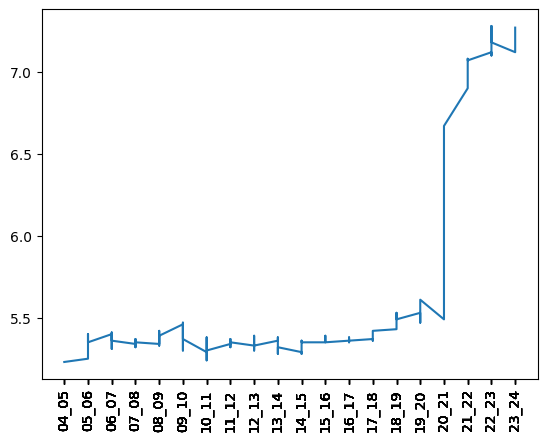

In [118]:
plt.plot(capfl_merged['Fiscal Year'], capfl_merged['Average Duration'])
plt.xticks(capfl_merged['Fiscal Year'], rotation = 90)
plt.show()

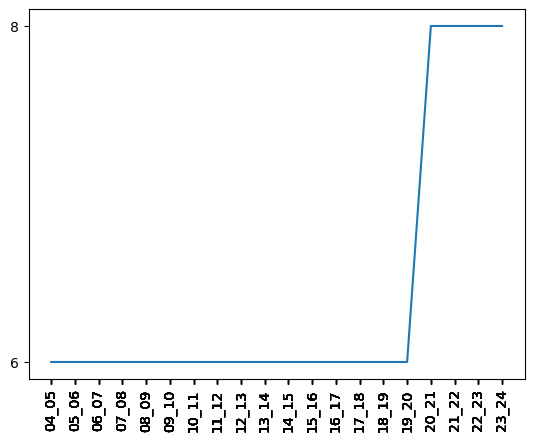

In [119]:
plt.plot(capfl_merged['Fiscal Year'], capfl_merged['max_num_weeks'])
plt.xticks(capfl_merged['Fiscal Year'], rotation = 90)
plt.show()

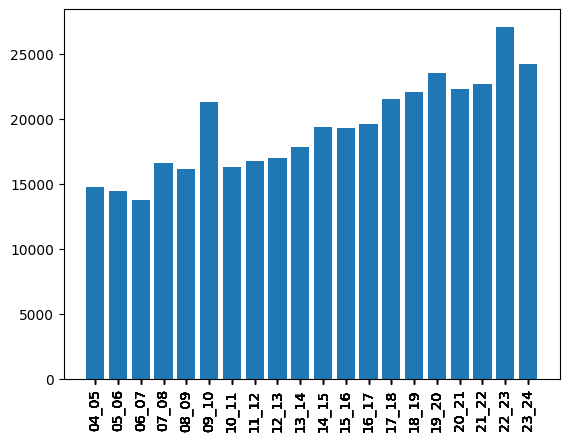

In [120]:
plt.bar(capfl_merged['Fiscal Year'], capfl_merged['Bonding Claims Paid'])
plt.xticks(capfl_merged['Fiscal Year'], rotation = 90)
plt.show()

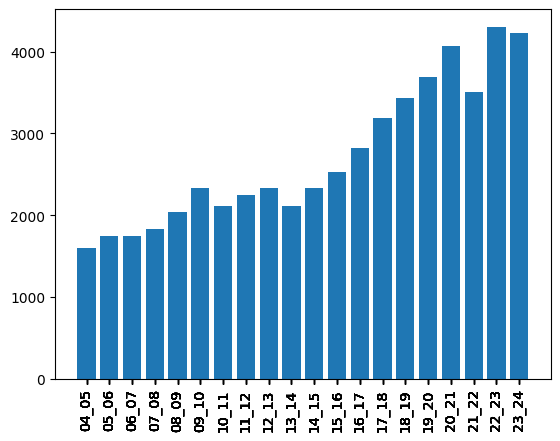

In [121]:
plt.bar(capfl_merged['Fiscal Year'], capfl_merged['Care Claims Paid'])
plt.xticks(capfl_merged['Fiscal Year'], rotation = 90)
plt.show()

In [122]:
capfl_merged['Fiscal Year'].describe()

count       239
unique       20
top       04_05
freq         12
Name: Fiscal Year, dtype: object

In [123]:
capfl_merged.groupby('Fiscal Year')['Bonding Claims Paid'].describe()

# df.groupby('period').describe()['Values'].drop('count', axis = 1).plot()

,count,mean,std,min,25%,50%,75%,max
Fiscal Year,,,,,,,,
04_05,12.0,10329.833333,2885.357323,2763.0,9678.75,10349.5,11593.75,14771.0
05_06,12.0,11385.250000,1389.647511,9775.0,10355.75,11094.0,12172.75,14423.0
06_07,12.0,12354.083333,827.104419,10959.0,11880.75,12428.0,12905.75,13787.0
07_08,12.0,13638.583333,1631.061977,11589.0,12528.75,13125.0,14454.50,16582.0
08_09,12.0,14137.333333,1563.584538,10719.0,13538.75,14367.5,14961.25,16153.0
09_10,12.0,13500.500000,3017.636507,8957.0,12076.75,12739.5,14091.75,21296.0
10_11,12.0,14453.666667,1332.281593,12303.0,13409.00,14491.0,15381.75,16312.0
11_12,12.0,14808.250000,1277.873811,13161.0,13751.50,14740.0,15741.75,16790.0
12_13,12.0,15007.000000,1509.333628,12817.0,13544.00,15269.0,16108.25,17024.0


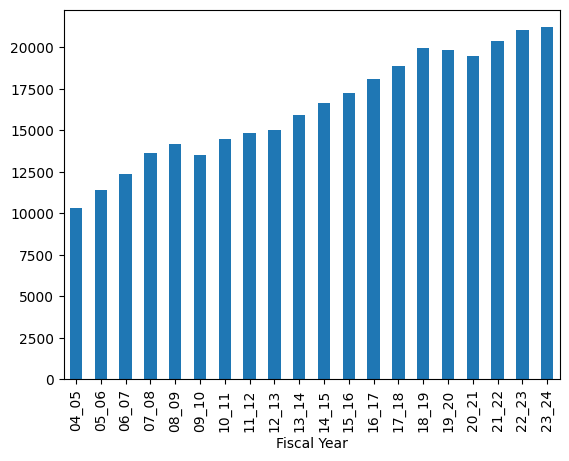

In [124]:
grouped_bonding_paid = capfl_merged.groupby('Fiscal Year')['Bonding Claims Paid'].mean()

# Plot the grouped data as a bar chart
grouped_bonding_paid.plot(kind='bar')
plt.show()

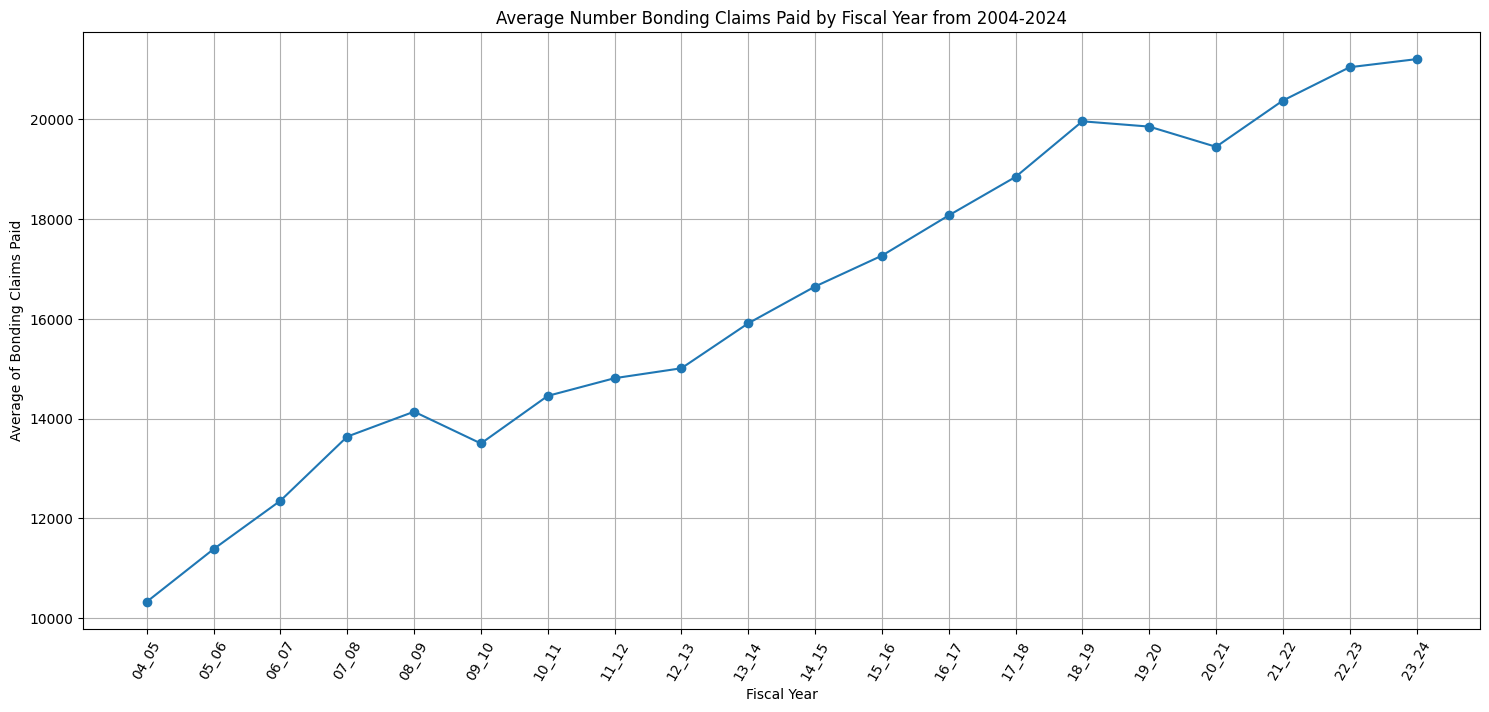

In [125]:
plt.figure(figsize=(15, 7))
plt.xlabel('Fiscal Year')
plt.ylabel('Average of Bonding Claims Paid')
plt.plot(grouped_bonding_paid, marker='o')

# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=60)
plt.tight_layout()

# start_date = pd.to_datetime('2019-01-01')
# end_date = pd.to_datetime('2022-12-01')
# plt.xlim(start_date, end_date)

plt.grid(True)

plt.title("Average Number Bonding Claims Paid by Fiscal Year from 2004-2024")

plt.show()

In [126]:
capfl_merged.columns

Index(['Fiscal Year', 'Month', 'Month_Num', 'Year',
       'Total PFL First Claims Filed', 'Bonding Claims Filed',
       'Care Claims Filed', 'Total PFL First Claims Paid',
       'Bonding Claims Paid', 'Care Claims Paid',
       'PFL Average Weekly Benefit Amount (AWBA)', 'Weeks Compensated',
       'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change',
       'max_num_weeks', 'births'],
      dtype='object')

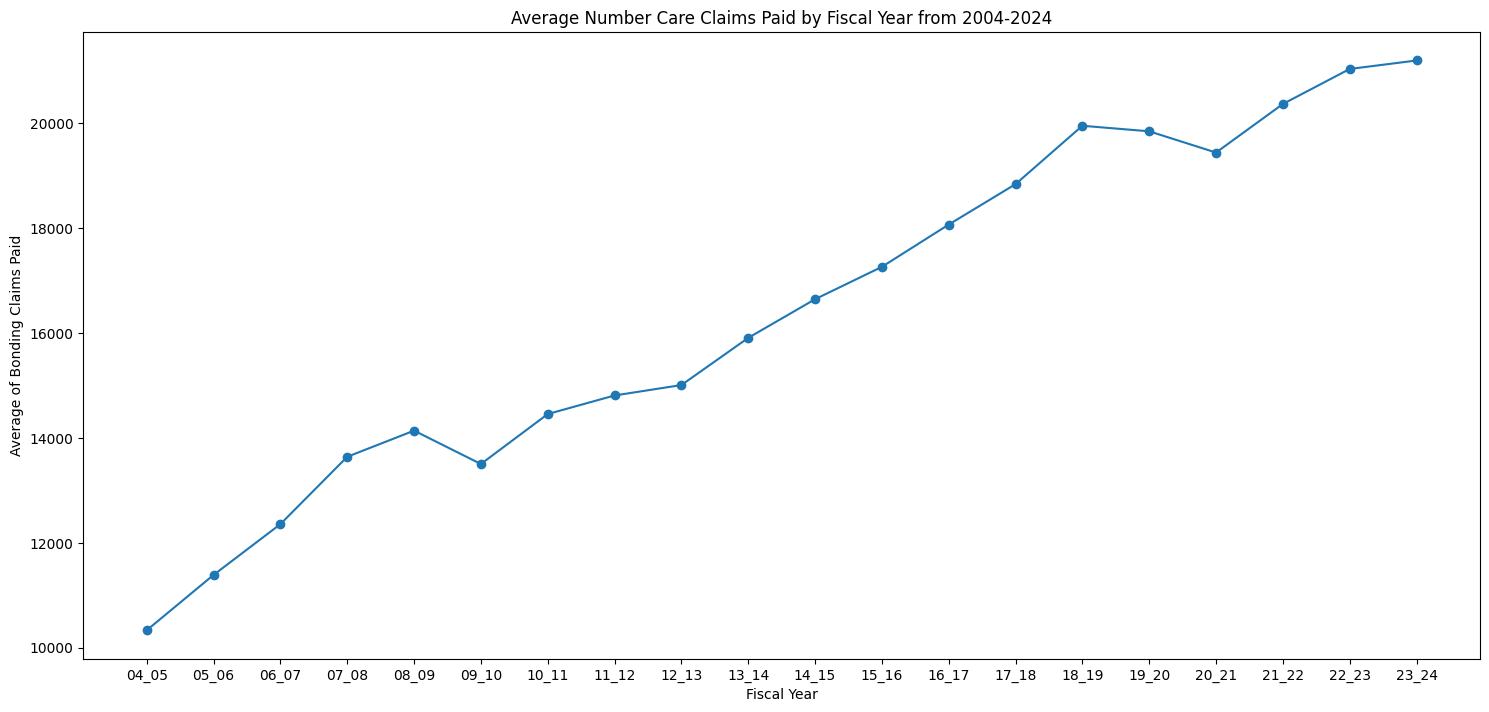

In [127]:
grouped_care_paid = capfl_merged.groupby('Fiscal Year')['Care Claims Paid'].mean()

plt.figure(figsize=(15, 7))
plt.xlabel('Fiscal Year')
plt.ylabel('Average of Bonding Claims Paid')
plt.plot(grouped_bonding_paid, marker='o')
plt.tight_layout()

# plt.grid(True)

plt.title("Average Number Care Claims Paid by Fiscal Year from 2004-2024")

plt.show()

In [128]:
capfl_merged.head()

,Fiscal Year,Month,Month_Num,Year,Total PFL First Claims Filed,Bonding Claims Filed,Care Claims Filed,Total PFL First Claims Paid,Bonding Claims Paid,Care Claims Paid,...,Total Benefits Authorized Logged,median_income,median_income_logged,median_income_weekly,median_55%,median_income_weekly_logged,max_amt,max_amt_change,max_num_weeks,births
Date,,,,,,,,,,,,,,,,,,,,,
2004-07-31,04_05,July,7,2004,5296,2916,2380,3621,2763,858,...,6.707226,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-08-31,04_05,August,8,2004,18885,16503,2382,16214,14771,1443,...,7.504857,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-09-30,04_05,September,9,2004,12555,10904,1651,11898,10506,1405,...,7.392789,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-10-31,04_05,October,10,2004,12890,11126,1764,11581,10157,1489,...,7.389731,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667
2004-11-30,04_05,November,11,2004,11571,10037,1534,10922,9722,1265,...,7.398271,49220.0,4.692142,946.538462,520.596154,2.976138,603.0,NaN,6,45390.416667


In [129]:
capfl_merged['births'].dtype

dtype('float64')

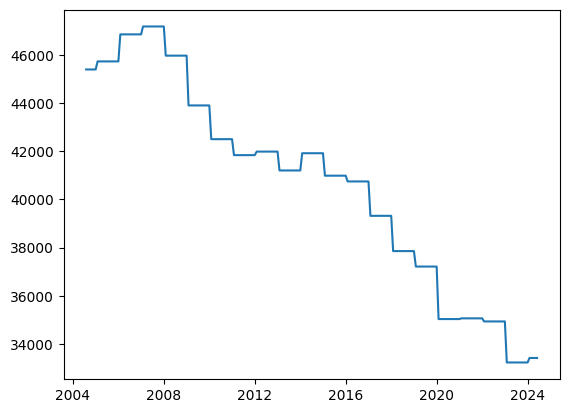

In [130]:
plt.plot(capfl_merged['births'])
plt.show()

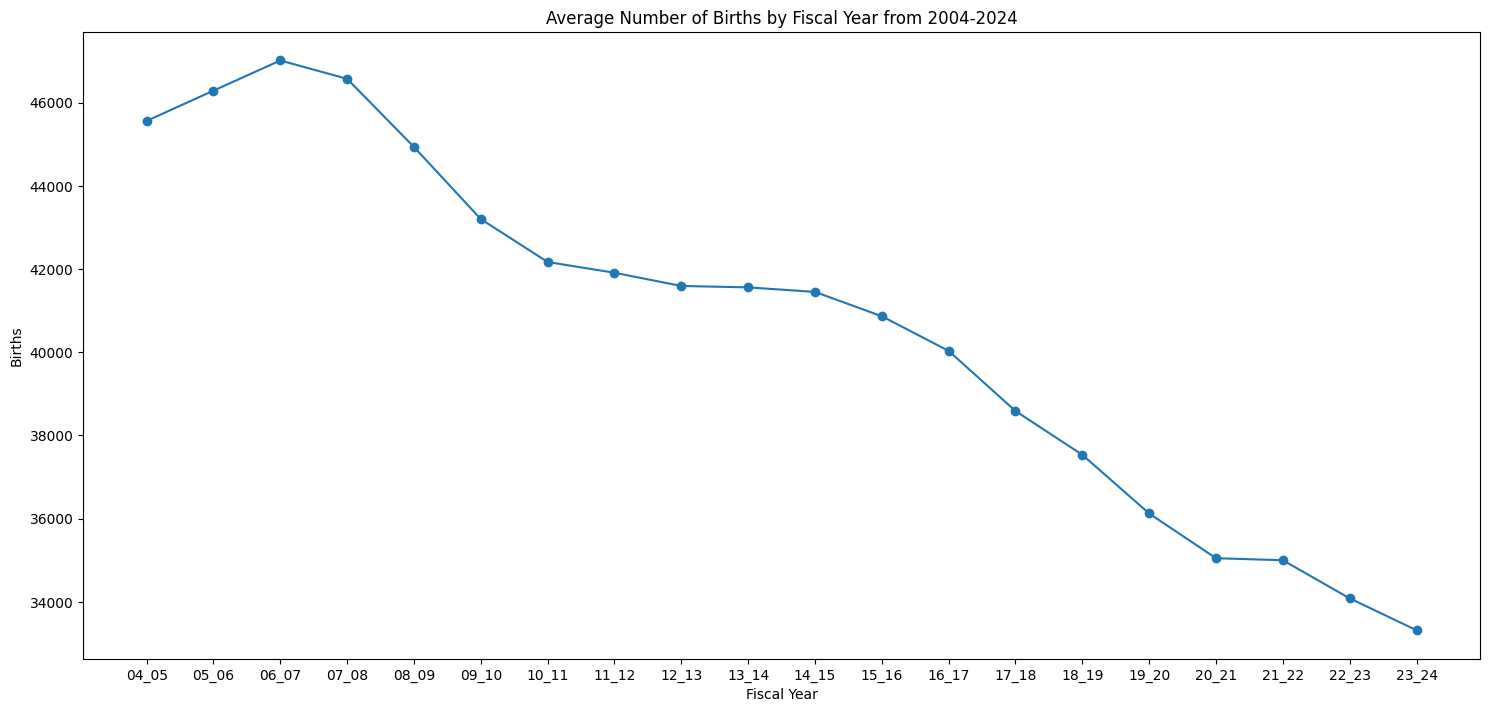

In [131]:
num_births = capfl_merged.groupby('Fiscal Year')['births'].mean()

plt.figure(figsize=(15, 7))
plt.xlabel('Fiscal Year')
plt.ylabel('Births')
plt.plot(num_births, marker='o')
plt.tight_layout()

# plt.grid(True)

plt.title("Average Number of Births by Fiscal Year from 2004-2024")

plt.show()

In [132]:
capfl_merged.to_csv('capfl_01142025.csv')

### **Recreating Tableau**

In [135]:
capfl_merged.columns

Index(['Fiscal Year', 'Month', 'Month_Num', 'Year',
       'Total PFL First Claims Filed', 'Bonding Claims Filed',
       'Care Claims Filed', 'Total PFL First Claims Paid',
       'Bonding Claims Paid', 'Care Claims Paid',
       'PFL Average Weekly Benefit Amount (AWBA)', 'Weeks Compensated',
       'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change',
       'max_num_weeks', 'births'],
      dtype='object')

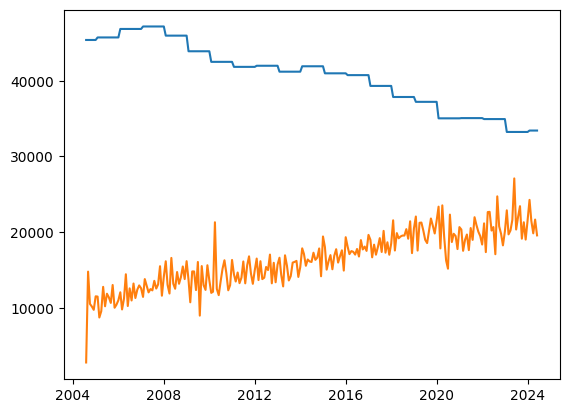

In [137]:
plt.plot(capfl_merged['births'])
plt.plot(capfl_merged['Bonding Claims Paid'])
plt.show()

<Axes: xlabel='Year', ylabel='Bonding Claims Paid'>

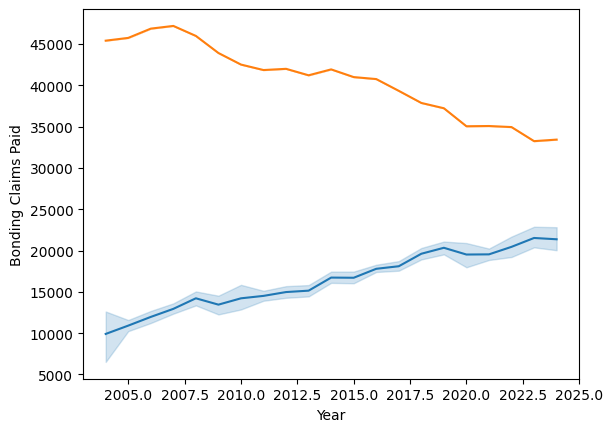

In [141]:
sns.lineplot(data = capfl_merged, x = 'Year', y = 'Bonding Claims Paid')
sns.lineplot(data = capfl_merged, x = 'Year', y = 'births')
sns.

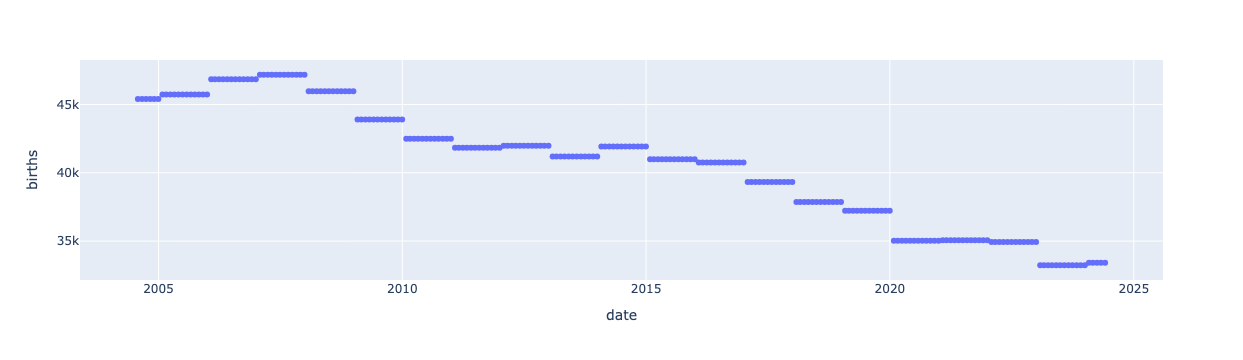

In [166]:
fig = px.scatter(births, x=births.index, y="births")
fig.show()

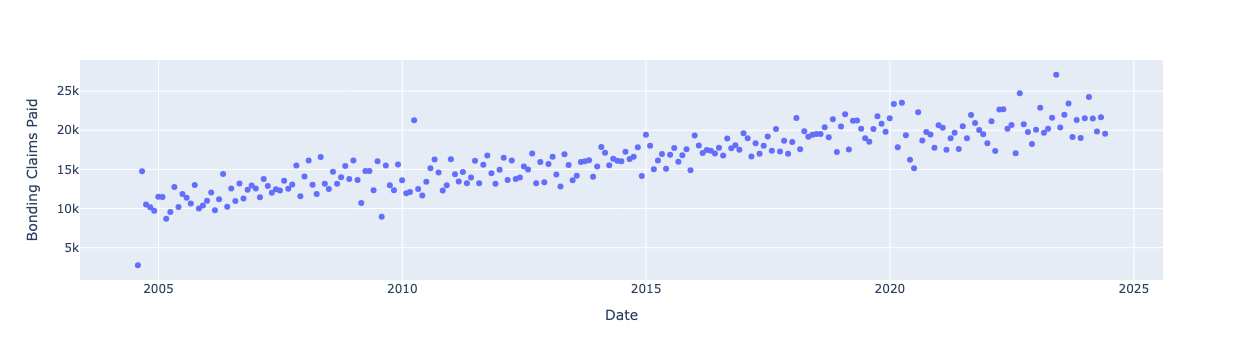

In [167]:
fig = px.scatter(capfl_merged, x=capfl_merged.index, y="Bonding Claims Paid")
fig.show()

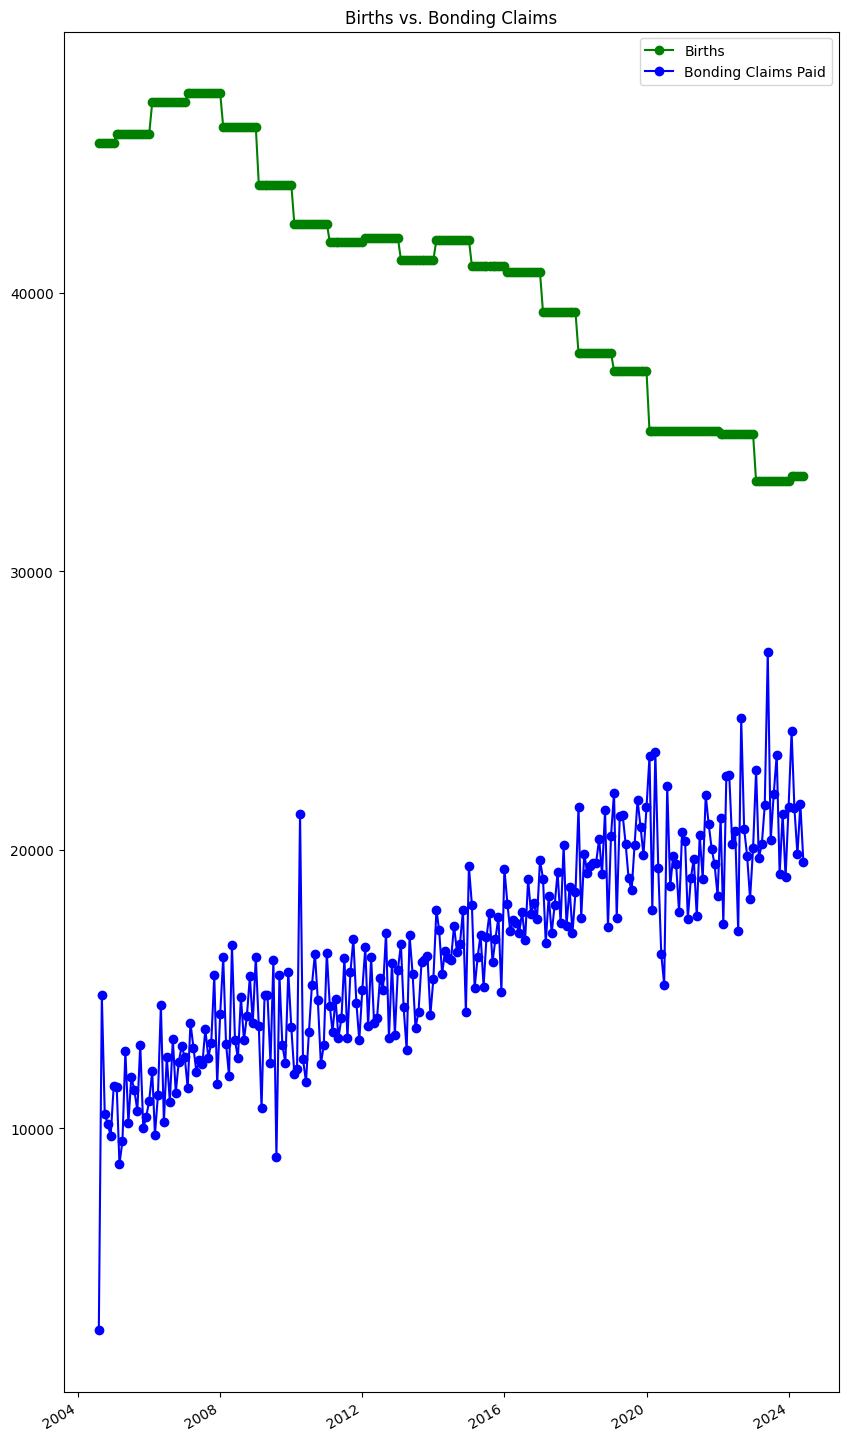

In [164]:
from matplotlib import rcParams
from matplotlib.widgets import Cursor 

f, ax = plt.subplots(1, 1)

ax.plot_date(births.index, births["births"], color="green", label="Births", linestyle="-")
ax.plot_date(capfl_merged.index, capfl_merged["Bonding Claims Paid"], color="blue", label="Bonding Claims Paid", linestyle="-")

ax.legend()
ax.set_title('Births vs. Bonding Claims')
rcParams['figure.figsize'] = 1,5

plt.gcf().autofmt_xdate()
plt.show()

In [185]:
def distribution(df, drop_columns = False):
    
    """"
    Creates a histogram and box plot of columns in a dataframe
    """
    if drop_columns != False:
        df = df.drop(columns = drop_columns)
    
    num_vars = len(df.columns)
    
    fig, axes = plt.subplots(num_vars, 2, figsize=(12, 5 * num_vars))
    
    for i, column in enumerate(df.columns):
        # Histogram on the first column of the current row
        sns.histplot(df[column], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Histogram of {column}')

        # Boxplot on the first column of the current row
        sns.boxplot(x=df[column], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {column}')
    
    
    plt.tight_layout()
    plt.show()


In [186]:
capfl_merged.columns

Index(['Fiscal Year', 'Month', 'Month_Num', 'Year',
       'Total PFL First Claims Filed', 'Bonding Claims Filed',
       'Care Claims Filed', 'Total PFL First Claims Paid',
       'Bonding Claims Paid', 'Care Claims Paid',
       'PFL Average Weekly Benefit Amount (AWBA)', 'Weeks Compensated',
       'Average Duration', 'Total Benefits Authorized',
       'Total Benefits Authorized Logged', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change',
       'max_num_weeks', 'births'],
      dtype='object')

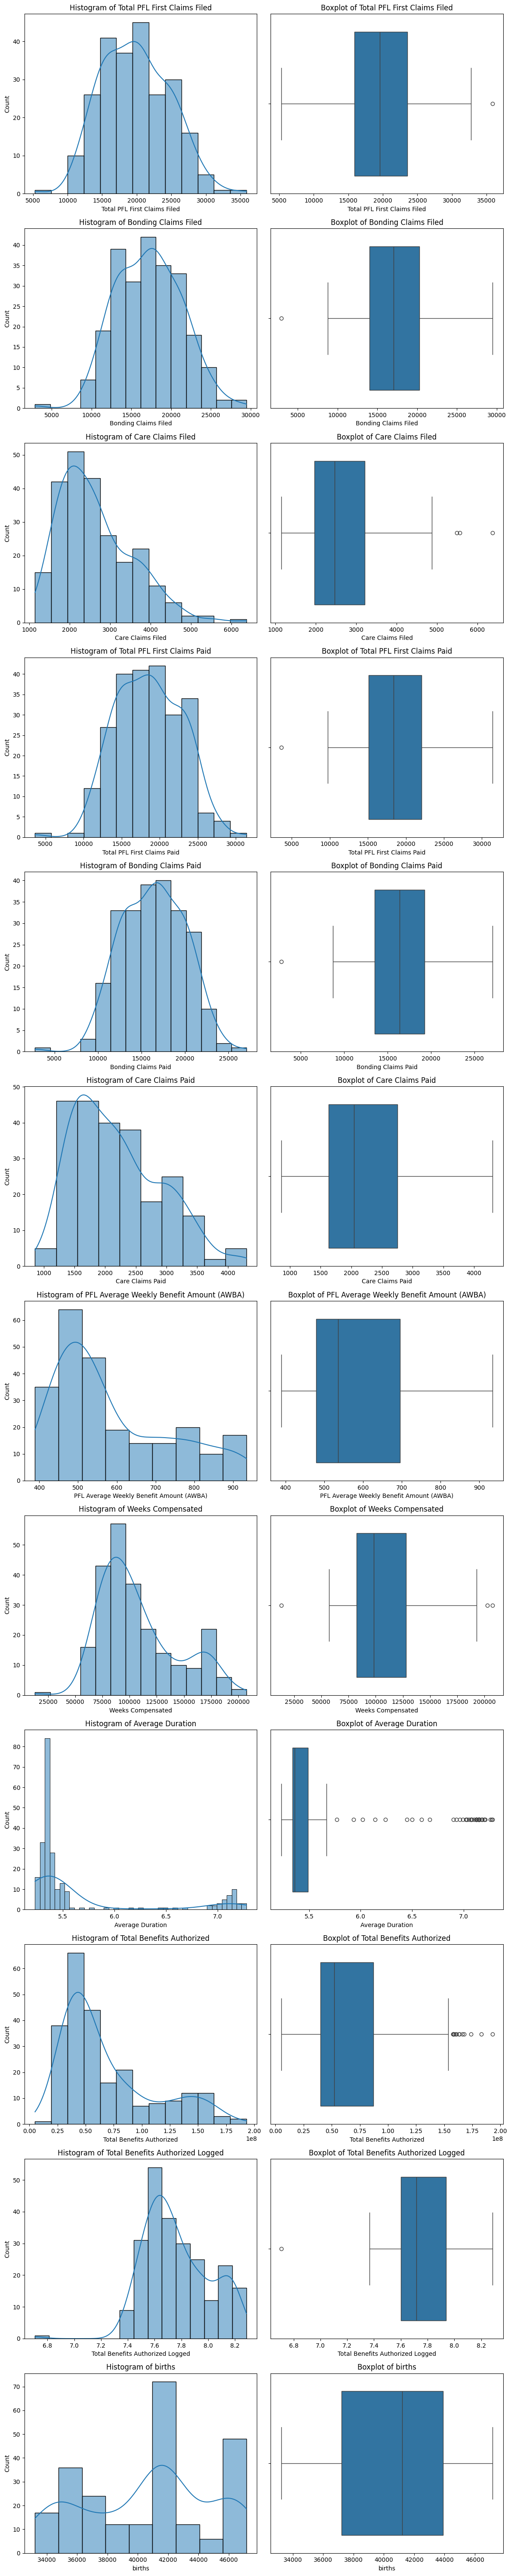

In [187]:
dropped_list = ['Fiscal Year', 'Month', 'Month_Num', 'Year', 'median_income',
       'median_income_logged', 'median_income_weekly', 'median_55%',
       'median_income_weekly_logged', 'max_amt', 'max_amt_change',
       'max_num_weeks']
distribution(capfl_merged, dropped_list)